In [1]:
import numpy as np
import easypde
import matplotlib.pyplot as plt

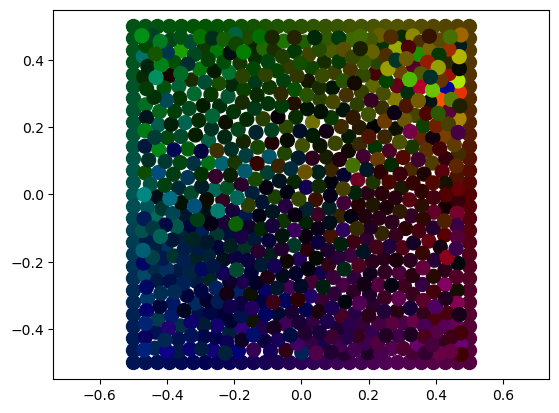

In [247]:
np.random.seed(0)
points = easypde.pointcloud.scatter_points_on_square(800) - 0.5

A = np.zeros((len(points), len(points)), dtype=np.complex64)
b = np.zeros(len(points), dtype=np.complex64)
weight_distribution_radius = easypde.pointcloud.get_typical_distance(points)*0.1
for i, point in enumerate(points):
    x = point[0]
    y = point[1]
    if abs(x) == 0.5 or abs(y) == 0.5:  # On boundary
        z = x + 1j * y
        z /= np.abs(z)
        easypde.edit_A_and_b(i, A, b, points, point, 5, [1, 0, 0, 0, 0, 0],
                             value=z,
                             weight_distribution_radius=weight_distribution_radius,
                             dtype=np.complex64)
    else:  # Internal
        easypde.edit_A_and_b(i, A, b, points, point, 16, [0, 1, 1j, 0, 0, 0],
                             weight_distribution_radius=weight_distribution_radius,
                             dtype=np.complex64)

solution = np.linalg.solve(A, b)

easypde.plot_points(points, field=solution, color_map='complex_hsv', point_size=10)

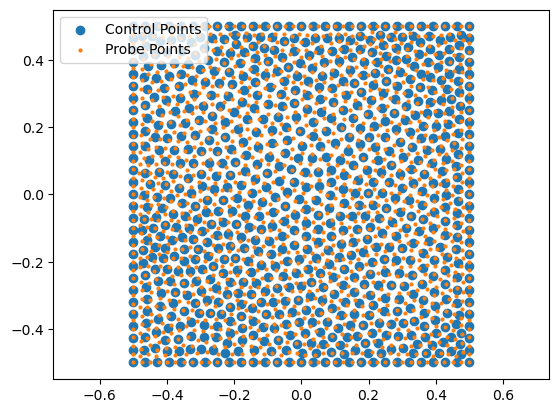

In [249]:
np.random.seed(0)
control_points = easypde.pointcloud.scatter_points_on_square(800) - 0.5
probe_points = easypde.pointcloud.scatter_points_on_square(1600) - 0.5

easypde.plot_points(control_points, plt_show=False, label="Control Points")
easypde.plot_points(probe_points, point_size=2, plt_show=False, label="Probe Points")
plt.legend()
plt.show()

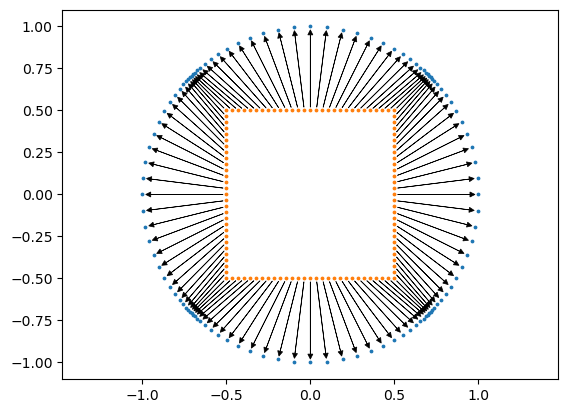

In [239]:
control_points_boundary = control_points[np.max(np.abs(control_points), axis=-1) == 0.5]
z1 = control_points_boundary[:, 0] + 1j * control_points_boundary[:, 1]

z2 = z1 / np.abs(z1)
z2 *= 1 + z2 ** 4 * 0.117 - z2 ** 8 * 0.011 + z2 ** 12 * 0.003  # By adjusting these parameters, we minimize the error
z2 /= np.abs(z2)

plt.scatter(z2.real, z2.imag, s=3)
plt.scatter(z1.real, z1.imag, s=3)
arrow_head_size = 0.03
for e1, e2 in zip(z1, z2):
    v = e2 - e1
    v /= abs(v)
    e1 += v * 0.02
    e2 -= v * (0.02 + arrow_head_size)
    v = e2 - e1
    plt.arrow(e1.real, e1.imag, v.real, v.imag, head_width=arrow_head_size, head_length=arrow_head_size, fc='black', linewidth=0.5)
plt.axis('equal')
plt.show()

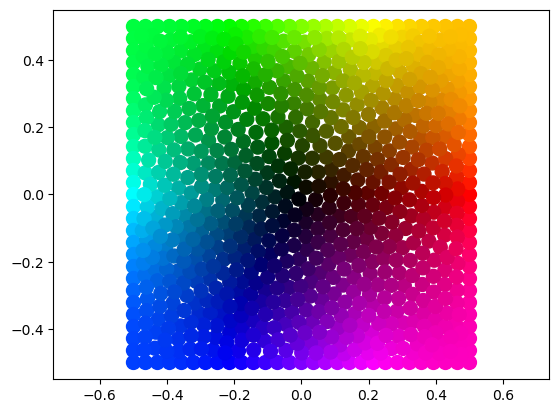

In [253]:
A = np.zeros((len(probe_points), len(control_points)), dtype=np.complex64)
b = np.zeros(len(probe_points), dtype=np.complex64)
weight_distribution_radius = easypde.pointcloud.get_typical_distance(control_points) * 0.1
for i, point in enumerate(probe_points):
    x = point[0]
    y = point[1]
    if abs(x) == 0.5 or abs(y) == 0.5:  # On boundary
        z = x + 1j * y
        z /= np.abs(z)
        z *= 1 + z ** 4 * 0.117 - z ** 8 * 0.011 + z ** 12 * 0.003  # By adjusting these parameters, we minimize the error
        z /= np.abs(z)
        easypde.edit_A_and_b(i, A, b, control_points, point, 5, [1, 0, 0, 0, 0, 0],
                             value=z,
                             weight_distribution_radius=weight_distribution_radius,
                             dtype=np.complex64)
    else:  # Internal
        easypde.edit_A_and_b(i, A, b, control_points, point, 16, [0, 1, 1j, 0, 0, 0],
                             weight_distribution_radius=weight_distribution_radius,
                             dtype=np.complex64)

solution = np.linalg.lstsq(A, b, rcond=None)[0]  # Here we replace np.linalg.solve with np.linalg.lstsq because the matrix is not square

easypde.plot_points(control_points, field=solution, color_map='complex_hsv', point_size=10)

error = 0.008065063506364822


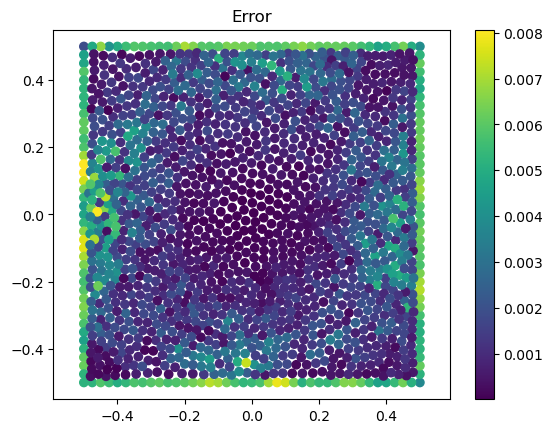

In [254]:
error = np.abs(A @ solution - b)
easypde.plot_points(probe_points, field=error, plt_show=False)
plt.title('Error')
plt.plot()
print(f'error = {np.max(error)}')